# BayesNF

Run for 2023 amd predict

In [25]:
import jax

jax.default_backend()

'METAL'

In [26]:
## -----------------------
## Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime
from sklearn import ensemble
import rbf_utils

In [27]:
## -----------------------
## Prep grid (mostly for bounds)
grid_gdf = gpd.read_file("./data/coarse_grid_pts/grid_pts_coarse.shp")
grid_gdf = grid_gdf.set_crs(4326, allow_override=True)
grid_gdf = grid_gdf.to_crs(32612)

## Grid min/max (replaced by set limits below)
grid_crds = grid_gdf.get_coordinates()
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()

## Updated to help estimate of basis functions
min_x = 393500
max_x = 453500
min_y = 4472000
max_y = 4532000
print(min_x, max_x, min_y, max_y)



393500 453500 4472000 4532000


In [28]:
## -----------------------
## Air monitor data
# aq_df = pd.read_csv("./data/loop_test/summer23_ozone_stationary.csv")
aq_df = pd.read_csv("./data/aq2023/stationary_o3.csv")
# aq_df['day_time'] = pd.to_datetime(aq_df['day_time']).dt.tz_localize(None)
## add the timezone:
# aq_df['day_time'] = aq_df['day_time'] + pd.Timedelta(hours=7)

aq_df['date_time'] = pd.to_datetime(aq_df['date']) + pd.to_timedelta(aq_df['hour'], unit='h') + pd.Timedelta(minutes=30)


In [29]:
aq_df.head(10)

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement,date_time
0,2005,40.598056,-111.894167,Ozone,2022-12-14 01:00:00,2022-12-14,1,0.023,2022-12-14 01:30:00
1,2005,40.598056,-111.894167,Ozone,2022-12-14 02:00:00,2022-12-14,2,0.024,2022-12-14 02:30:00
2,2005,40.598056,-111.894167,Ozone,2022-12-14 03:00:00,2022-12-14,3,0.020,2022-12-14 03:30:00
3,2005,40.598056,-111.894167,Ozone,2022-12-14 04:00:00,2022-12-14,4,0.023,2022-12-14 04:30:00
4,2005,40.598056,-111.894167,Ozone,2022-12-14 05:00:00,2022-12-14,5,0.021,2022-12-14 05:30:00
5,2005,40.598056,-111.894167,Ozone,2022-12-14 06:00:00,2022-12-14,6,0.020,2022-12-14 06:30:00
6,2005,40.598056,-111.894167,Ozone,2022-12-14 07:00:00,2022-12-14,7,0.015,2022-12-14 07:30:00
7,2005,40.598056,-111.894167,Ozone,2022-12-14 08:00:00,2022-12-14,8,0.014,2022-12-14 08:30:00
8,2005,40.598056,-111.894167,Ozone,2022-12-14 09:00:00,2022-12-14,9,0.013,2022-12-14 09:30:00
9,2005,40.598056,-111.894167,Ozone,2022-12-14 10:00:00,2022-12-14,10,0.016,2022-12-14 10:30:00


In [30]:
## Convert to geopandas
aq_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(aq_df.longitude, aq_df.latitude, crs="EPSG:4326"), data=aq_df
)
aq_gdf = aq_gdf.to_crs(32612)

## Standardize coordinates
aq_crds = aq_gdf.get_coordinates()
lon = aq_crds.x
lat = aq_crds.y
# aq_df['normalized_east'] = (lon-min_x)/(max_x - min_x)
# aq_df['normalized_north'] = (lat-min_y)/(max_y-min_y)
# aq_df['east'] = aq_crds.x / 1e3
# aq_df['north'] = aq_crds.y / 1e3

aq_df['east'] = (lon-min_x)/(max_x - min_x)
aq_df['north'] = (lat-min_y)/(max_y-min_y)


In [31]:
## -----------------------
## EBus data
ebus = pd.read_csv("./data/aq2023/mobile_o3.csv", na_values = -9999.00)
ebus.head()

,times,LAT,LON,ELV,O3,O3F,ebus_trax
0,2022-12-14 00:01:00,40.76566,-111.90975,1278.0,11.0,0,ebus
1,2022-12-14 00:02:00,40.76562,-111.90976,1274.6,10.8,0,ebus
2,2022-12-14 00:03:00,40.76571,-111.90981,1274.2,9.2,0,ebus
3,2022-12-14 00:04:00,40.76574,-111.90977,1273.8,13.7,0,ebus
4,2022-12-14 00:05:00,40.76570,-111.90977,1273.7,12.6,0,ebus


In [32]:
ebus_df = pd.DataFrame({
    'date_time': pd.to_datetime(ebus['times'], errors='coerce'),
    'longitude': ebus['LON'],
    'latitude': ebus['LAT']
    })
ebus_df['val'] = ebus['O3'] / 1000
ebus_df.loc[pd.isnull(ebus_df['date_time']),'date_time'] = pd.to_datetime(ebus['times'][pd.isnull(ebus_df['date_time'])])

## Convert to geopandas
ebus_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(ebus_df.longitude, ebus_df.latitude, crs="EPSG:4326"), data=ebus_df
)
ebus_gdf = ebus_gdf.to_crs(32612)

## Standardize coordinates
ebus_crds = ebus_gdf.get_coordinates()
lon = ebus_crds.x
lat = ebus_crds.y
ebus_df['east'] = (lon-min_x)/(max_x - min_x)
ebus_df['north'] = (lat-min_y)/(max_y-min_y)

In [33]:
ebus_df.head()

,date_time,longitude,latitude,val,east,north
0,2022-12-14 00:01:00,-111.90975,40.76566,0.0110,0.495297,0.685695
1,2022-12-14 00:02:00,-111.90976,40.76562,0.0108,0.495282,0.685621
2,2022-12-14 00:03:00,-111.90981,40.76571,0.0092,0.495213,0.685788
3,2022-12-14 00:04:00,-111.90977,40.76574,0.0137,0.495270,0.685843
4,2022-12-14 00:05:00,-111.90977,40.76570,0.0126,0.495269,0.685769


In [34]:
aq_df.head()

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement,date_time,east,north
0,2005,40.598056,-111.894167,Ozone,2022-12-14 01:00:00,2022-12-14,1,0.023,2022-12-14 01:30:00,0.514062,0.375387
1,2005,40.598056,-111.894167,Ozone,2022-12-14 02:00:00,2022-12-14,2,0.024,2022-12-14 02:30:00,0.514062,0.375387
2,2005,40.598056,-111.894167,Ozone,2022-12-14 03:00:00,2022-12-14,3,0.020,2022-12-14 03:30:00,0.514062,0.375387
3,2005,40.598056,-111.894167,Ozone,2022-12-14 04:00:00,2022-12-14,4,0.023,2022-12-14 04:30:00,0.514062,0.375387
4,2005,40.598056,-111.894167,Ozone,2022-12-14 05:00:00,2022-12-14,5,0.021,2022-12-14 05:30:00,0.514062,0.375387


## Set up data for model

In [35]:
df_train = aq_df
df_test = ebus_df

train_sites = df_train['site.num'].unique()
print(f'Training: {train_sites}')

Training: [2005 3006 3010 3013 3014 3015 3016 4002]


In [36]:
all_days = aq_df.date.unique()
len(all_days)

383

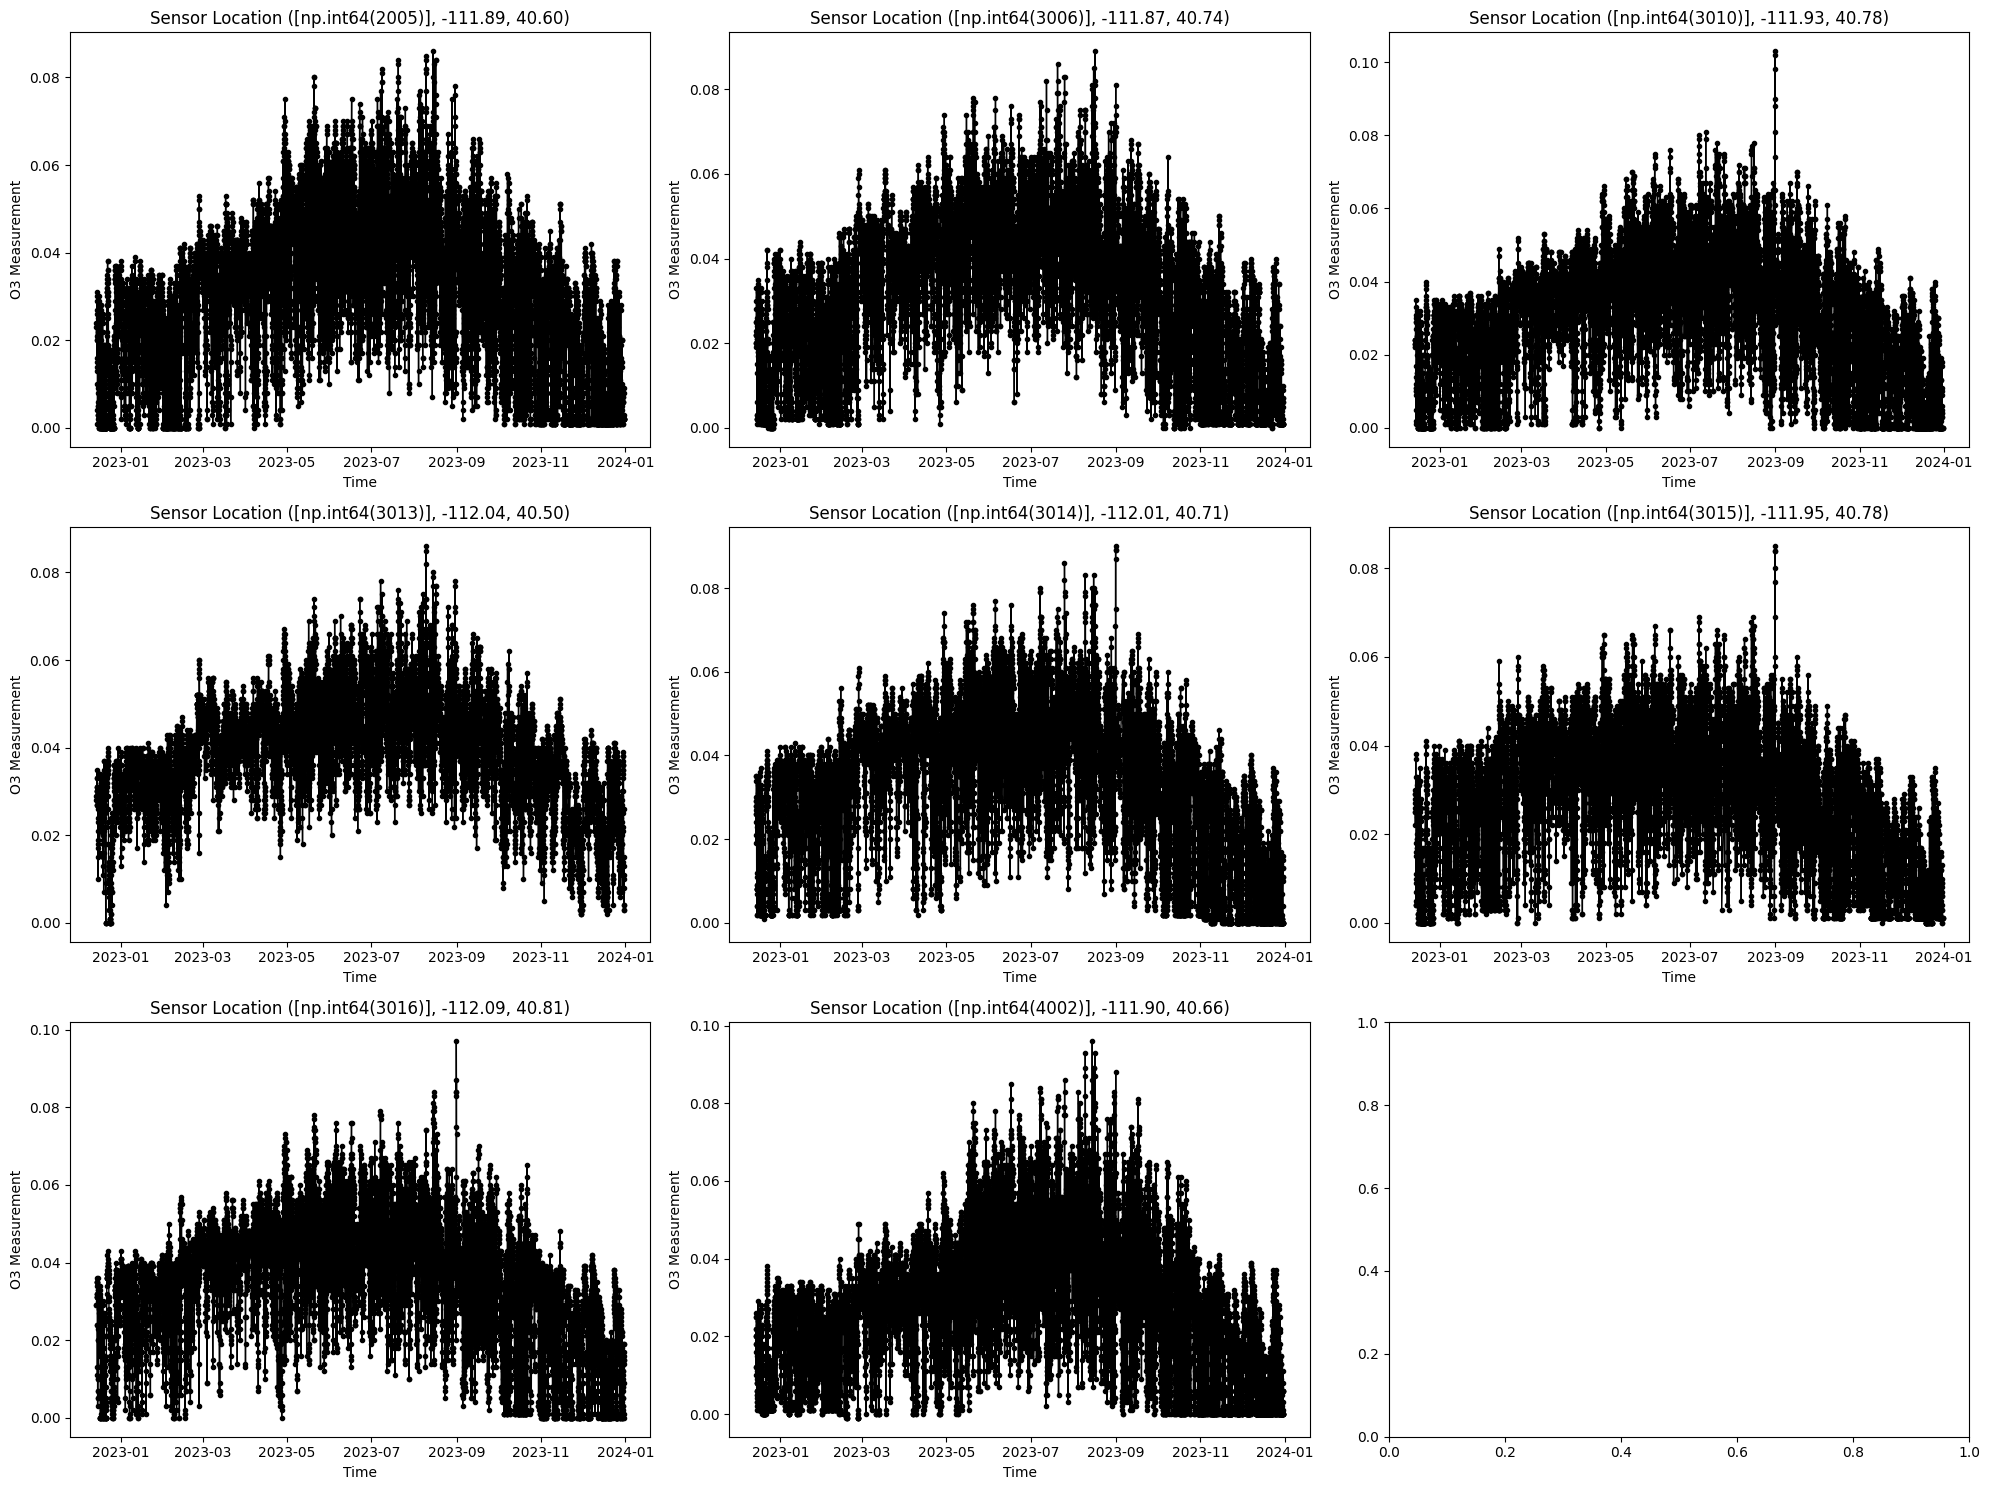

In [37]:
locations = df_train['site.num'].unique()
fig, axes = plt.subplots(ncols=3, nrows=3, tight_layout=True, figsize=(20,15))
for ax, location in zip(axes.flat, locations):
  df_location = df_train[df_train['site.num']==location]
  latitude, longitude = df_location.iloc[0][['latitude', 'longitude']]
  site_num = df_location.iloc[0][['site.num']].values
  ax.plot(df_location['date_time'], df_location['sample.measurement'], marker='.', color='k', linewidth=1)
  ax.set_title(f'Sensor Location ({site_num}, {longitude:.2f}, {latitude:.2f})')
  ax.set_xlabel('Time')
  ax.set_ylabel('O3 Measurement')

In [38]:
from bayesnf.spatiotemporal import BayesianNeuralFieldMAP

model = BayesianNeuralFieldMAP(
  width=512,
  depth=2,
  freq='H',
  seasonality_periods=['D', 'W'], # Daily and weekly seasonality, same as [24, 24*7]
  num_seasonal_harmonics=[4, 4], # Four harmonics for each seasonal factor.
  feature_cols=['date_time', 'latitude', 'longitude'], # time, spatial 1, ..., spatial n
  target_col='sample.measurement',
  observation_model='NORMAL',
  timetype='index',
  standardize=['latitude', 'longitude']
  )

In [39]:
df_train.shape

(72505, 11)

In [40]:
# Train MAP ensemble
model = model.fit(
    df_train,
    seed=jax.random.PRNGKey(0),
    ensemble_size=8,
    num_epochs=5000, 
    batch_size=1000
    )

/opt/homebrew/Caskroom/miniforge/base/envs/jax-metal/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:101: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  first_date = pd.to_datetime('2020-01-01').to_period(freq)
/opt/homebrew/Caskroom/miniforge/base/envs/jax-metal/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  table[time_column] = table[time_column].dt.to_period(freq)
/opt/homebrew/Caskroom/miniforge/base/envs/jax-metal/lib/python3.10/site-packages/bayesnf/spatiotemporal.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x = pd.date_range(y[0].start_time, y[-1].start_time).to_period(freq)


KeyboardInterrupt: 

In [ ]:
# Inspect the training loss for each particle.
import matplotlib.pyplot as plt
losses = np.row_stack(model.losses_)
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(losses.T)
ax.plot(np.mean(losses, axis=0), color='k', linewidth=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Negative Joint Probability')
ax.set_yscale('log', base=10)

In [ ]:
yhat, yhat_quantiles = model.predict(df_test, quantiles=(0.025, 0.5, 0.975))

In [ ]:
df_test

In [ ]:
plt.hist(df_test['val'])

In [ ]:
fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax.scatter(df_test['val'], yhat_quantiles[1], marker='.', color='k')
ax.plot([0.01, 0.08], [0.01, 0.08], color='red')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), tight_layout=True)
ax.plot(df_test['day_time'], df_test['val'], 'ko')
ax.plot(df_test['day_time'], yhat_quantiles[1])
#ax.fill_between(df_test['day_time'], yhat_quantiles[0], yhat_quantiles[2], alpha=0.5, label='95% Prediction Interval')


In [ ]:
df_test['yhat'] = yhat_quantiles[1]
df_test['yhat_lo'] = yhat_quantiles[0]
df_test['yhat_hi'] = yhat_quantiles[2]
df_test['adj'] = df_test['val'] - df_test['yhat']

In [ ]:
df_test.to_csv("./data/aq2023/adj_o3_2023.csv", index=False)